# Práctica de Selección de Instancias

## Índice de la práctica

- [Leave-one-out para kNN](#Leave-one-out-para-kNN)
- [Visualización de las fronteras de decisión](#Visualización-de-las-fronteras-de-decisión)
- [Métodos de selección de instancias](#Métodos-de-selección-de-instancias): ENN, AllKNN, CNN, RNN, RMHC
- [Comparación de los métodos con kNN](#Comparación-de-los-métodos-con-kNN)
- [Comparación de los métodos con Árboles de Decisión](#Comparación-de-los-métodos-con-Árboles-de-Decisión)

Comenzamos la práctica importando los paquetes necesarios. Como siempre, usaremos NumPy, Matplotlib y Scikit-learn.

In [41]:
import numpy as np
import category_encoders as ce
from sklearn import metrics, neighbors, tree, preprocessing
from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from shutil import copyfile

from test_helper import Test

%matplotlib inline  

# Leave-one-out para kNN
Lo primero que vamos a realizar en la práctica es la implementación de un modelo de leave-one-out para los k vecinos más cercanos. Este método es muy útil para valorar la calidad de los conjuntos de instancias seleccionadas. La idea es clasificar cada instancia con el resto de instancias como conjunto de entrenamiento (sin considerar a ella misma).

Si solo queremos hacer leave-one-out con el conjunto de entrenamiento, podríamos usar la librería de sklearn. Sin embargo, nosotros queremos evaluar un conjunto de instancias seleccionadas $S$ sobre el conjunto completo de entrenamiento $TR$. Aplicar leave-one-out en este caso, significa que queremos conocer la clasificación de todas las instancias en $TR$ usando $S$ como referencia ($S\subset TR$). Por tanto, cuando vayamos a clasificar una instancia que está seleccionada en $S$ no debemos considerar a ella misma como su propio vecino. Esto es lo que sklearn no permite hacer.

En la siguiente función vamos a implementar esa lógica utilizando algunas de las funciones de la clase neighbors.KNeighborsClassifier de sklearn: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

En dicha clase, tenemos una función llamada `kneighbors(X)` que nos devuelve los índices de los vecinos más cercanos cercanos a cada instancia en `X` y las distancias asociadas. Lo que vamos a hacer es obtener para cada ejemplo sus $k+1$ ejemplos más cercanos con sus distancias. Posteriormente, si la distancia del vecino más cercano es $0$, asumiremos que dicho vecino es el propio ejemplo y por tanto sustituiremos dicho vecino por el vecino $k+1$ que en otro caso no será considerado para la votación.

Además, como la función `kneighbors` nos devuelve el índice del vecino, pero no su clase, debemos transformar el índice a la clase correspondiente del propio vecino, para posteriormente poder calcular la clase más repetida entre los $k$ vecinos más cercanos (una vez eliminados los que tienen distancia 0).

In [42]:
def leaveOneOut(clasificador, X, y):
    """
    :param clasificador: Instancia de un clasificador de Scikit-Learn entrenada (con fit hecho con los datos de train o el subconjunto seleccionado)
    :param X: Matriz con los ejemplos de entrenamiento completo (para hacer leave one out)
    :param y: Vector con la salida de los ejemplos de entrenamiento completo (correspondientes a X)
    :return: Vector con la salida obtenida para cada ejemplo de X (siguiendo el esquema leave-one-out)
    """
    # En caso de que el clasificador no sea KNN simplemente se utiliza el clasificador aprendido y se predicen los ejemplos con dicho clasificador
    if type(clasificador) != neighbors.KNeighborsClassifier:
        # Utiliza el método predict para obtener la predicción
        prediction = clasificador.predict(X)
        return prediction
    
    # En otro caso será una instancia de KNeighborsClassifier
    # kneighbors nos devuelve los vecinos más cercanos de cada ejemplo en X y las distancias asociadas
        # distancias y vecinos serán matrices de numEjemplos x k+1 elementos
    distancias,vecinos = clasificador.kneighbors(X, n_neighbors=clasificador.n_neighbors + 1, return_distance=True)
    # Realmente no estamos interesados en el propio vecino, sino en la clase a la que pertenece
    # Transformamos los vecinos a una matriz con la clase de cada vecino
    # Accedemos a las clases de los ejemplos de entrenamiento (atributo _y del clasificador knn) 
        # y cogemos los elementos en las posiciones de los vecinos calculados anteriormente
    vecinosClase = clasificador._y[vecinos]
    
    # Ahora queda decidir la clase de salida para cada uno de los ejemplos
    # Debemos tener en cuenta: Si la distancia al primer vecino es 0, el vecino es el propio ejemplo y por tanto no lo usamos para decidir
    #   1. Obtenemos una máscara con los ejemplos en los que ocurre esto
    #   2. Sustituimos la clase del primer vecino por la del último (el k+1 que sino no se utiliza)
    #   3. Obtenemos la moda (stats.mode) (el valor más repetido de clase) para cada fila (cogiendo los k primeros valores)
    mascara = (distancias[:,0] == 0)
    vecinosClase[mascara,0]=vecinosClase[mascara, clasificador.n_neighbors]
    prediction,_ = stats.mode(vecinosClase[:,:-1], 1)

    return prediction

En esta práctica vamos a trabajar con dos conjuntos de datos muy diferentes: banana e iris.

Banana es un dataset artificial con dos clases y dos atributos reales. Tiene alrededor de 5000 instancias por lo que las ejecuciones serán algo más lentas con él. El dataset resulta interesante porque nos permita estudiar de manera simple y visual el comportamiento de los modelos de selección de instancias.

Iris es un dataset que ya habéis utilizado anteriormente, se trata de un problema de clasificación en el que se deben distinguir tres tipos de plantas iris según las cuatro características reales establecidas. Para poder trabajar visualmente con dicho dataset, en esta práctica utilizaremos una modificación del mismo en el que utilizaremos únicamente las dos últimas características. El dataset ya está transformado para tal fin.

En primer lugar, debéis crear una función que reciba como parámetros de entrada el nombre de un fichero que contenga los datos del problema y el nombre de la variable a predecir. La función debe leer los datos del fichero y generar los DataFrames X (información de las variables de entrada) e y (información de la variable de salida) de acuerdo a una codificación ordinal (restando 1 para que la primera clase sea la 0). La función debe devolver como salida los DataFrames X e y.

In [43]:
def lecturaDatos(path,nombreAtSalida):
    data = pd.read_csv(path)
    
    y =  data[nombreAtSalida].copy()
    X = data.drop([nombreAtSalida], axis=1).copy()
    
    #Codificacion ordinal
    myEncoder = ce.ordinal.OrdinalEncoder()
    y = myEncoder.fit_transform(y) - 1
    
    return X, y.Class.values

A continuación vamos a comprobar si la función *leaveOneOut* funciona correctamente.

Para ello, vamos a realizar el código en el que vamos a leer los datos de entrenamiento y los de test para cada dataset y normalizamos los datos con el método de los máximos y mínimos (llevando los datos a [0, 1]). La normalización es necesaria para aplicar $k$NN.

Vamos a guardar dos diccionarios, uno con los datasets `nombre dataset -> (conjunto train X, conjunto train y, conjunto test X, conjunto test y)` y otro con el objeto de la clase utlizada para realiar la normalización `nombre dataset -> min_max_scaler` (este segundo lo reutilizaremos al final de la práctica). Necesitamos el diccionario ya que cada dataset tendrá su propia normalización asociada a los valores máximos y mínimos de sus atributos.

In [44]:
# Establecemos los nombres de los datasets a utilizar
nombresDatasets = ['iris','banana']
# Inicializamos los diccionarios
datasets = {}
min_max_scaler = {}

# Para cada dataset realizamos las operaciones
for dataset in nombresDatasets:
    # Establecemos el nombre de los ficheros de train y de test
    fileTr = '-5dobscv-2tra.csv'
    fileTst = '-5dobscv-2tst.csv'
    # Leemos los datos con la función creada anteriormente
    X_train, y_train = lecturaDatos(dataset+fileTr,'Class')
    X_test, y_test = lecturaDatos(dataset+fileTst,'Class')
    # Creamos la instancia para la normalización 
    min_max_scaler[dataset] = preprocessing.MinMaxScaler()
    # Ajustamos la normalización con X_train (fit_transform) y la aplicamos a X_test (transform)
    X_train = min_max_scaler[dataset].fit_transform(X_train)
    X_test = min_max_scaler[dataset].transform(X_test)

    # Finalmente almacenamos el dataset en formato de tupla (X_train, y_train, X_test_ y_test)
    datasets[dataset] = (X_train, y_train, X_test ,y_test)
    print("Ejemplos por clase en " + dataset + ":")
    print(np.bincount(y_train))

Ejemplos por clase en iris:
[40 40 40]
Ejemplos por clase en banana:
[2339 1901]


In [45]:
Test.assertEquals(list(np.bincount(datasets['iris'][1])), [40, 40, 40], "Iris no está leído correctamente")
Test.assertEquals(list(np.bincount(datasets['banana'][1])), [2339, 1901], "Banana no está leído correctamente")

1 test passed.
1 test passed.


# Visualización de las fronteras de decisión
Para poder comprender mejor el funcionamiento de los métodos de selección de instancias vamos a basarnos en la visualización de las instancias (es por esto que estamos usando datasets con solo dos características).

Vamos a crear un función llamada *mostrar* que nos va a permitir mostrar gráficamente los resultados obtenidos. Queremos:
1. **Mostrar los ejemplos utilizados como referencia en kNN en una gráfica junto con la frontera de decisión** que definen. En el caso de no haber procesado el dataset, este será el conjunto de train, pero en caso de haber realizado una selección de instancias mostraremos únicamente dichas instancias ya que son las utilizadas para entrenar el clasificador.
2. En caso de no **mostrar los ejemplos de entrenamiento** en la primera figura debido a que hemos realizado la selección de instancias, mostraremos dichos ejemplos en otra gráfica con la frontera de decisión definida por los ejemplos seleccionados.
3. **Mostramos los ejemplos de test sobre las fronteras de decisión del clasificador** (observaremos cuáles se fallan a la hora de generalizar a un conjunto de datos no visto en el entrenamiento ni en la selección de instancias).

In [46]:
def mostrar(clasificador, X, y, Xtst, ytst, method=None, Xsel=None, ysel=None):
    """
    Esta función muestra las fronteras de decisión del clasificador ya entrenado y los ejemplos en X
    (con el color dependiendo de y). En caso de pasar valores para los parámetros Xsel e ysel, dibuja una nueva
     figura con los prototipos utilizados para crear el clasificador
    :param clasificador: Clasificador entrenado 
    :param X: Matriz con los ejemplos a mostrar
    :param y: Vector con las salidas de los ejemplos a mostrar
    :param method: String con el nombre del método de selección de instancias utilizado
    :param Xsel: Matriz con los prototipos seleccionados
    :param ysel: Vector con las clases de los prototipos seleccionados
    :return: Nada
    """
    h = .02  # Tamaño de paso para la malla

    # Creamos los mapas de colores a utilizar
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
    # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() * 0.9, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 0.9, X[:, 1].max() * 1.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Clasificamos los puntos
    Z = clasificador.predict(np.c_[xx.ravel(), yy.ravel()])
    # Ponemos el resultado en el formato deseado
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(17,5.5))

    # En caso de pasar los prototipos seleccionados, pintamos su figura a la izquierda
    if Xsel is not None:
        plt.subplot(131)
        # Pintamos las fronteras
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        # Pintamos los puntos
        plt.scatter(Xsel[:, 0], Xsel[:, 1], c=ysel, cmap=cmap_bold, facecolor='none')
        # Asignamos el título
        plt.title("Ejemplos seleccionados con %s" % (method))
        # Establecemos los límites
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.subplot(132)
    else:
        plt.subplot(121)

    # Pintamos la figura de los ejemplos en X (a la izquierda si ya hemos pintado la primera)
    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Pintamos los puntos
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Train")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Pintamos la figura de los ejemplos en Xtst (a la izquierda si ya hemos pintado la primera)
    if Xsel is not None:
        plt.subplot(133)
    else:
        plt.subplot(122)

    # Pintamos las fronteras
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Pintamos los puntos de test
    plt.scatter(Xtst[:, 0], Xtst[:, 1], c=ytst, cmap=cmap_bold)
    # Asignamos el título
    plt.title("Ejemplos de Test")
    # Establecemos los límites
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    if type(clasificador) == neighbors.KNeighborsClassifier:
        plt.suptitle('Clasificador: %iNN' % (clasificador.n_neighbors), fontsize=16)
    else:
        plt.suptitle('Clasificador: Decision Tree', fontsize=16)

    # Mostramos la figura
    plt.show()
    return

Una vez leídos los conjuntos de datos y generada la funcion para mostrar las fronteras de decisión, es hora de probar el método de leaveOneOut implementado. Para ello, vamos a crear el clasificador kNN con `n_neighbors=1`. Posteriormente, evaluaremos cada dataset en train (con `leaveOneOut`) y en test (directamente con `knn.predict`). En ambos casos, para obtener la precisión podemos utilizar las métricas que nos provee sklearn. En este caso, nos centraremos en la precisión o porcentaje de acierto que podemos obtener utilizando `metrics.accuracy_score` a la cual debemos pasar un vector con la salida dada por el clasificador para cada ejemplo y otro vector con la salida real para cada uno de ellos.

Dataset iris
Resultados sin pre-procesar con 1NN
Precisión en train: 0.9666666666666667
Precisión en test: 0.9333333333333333


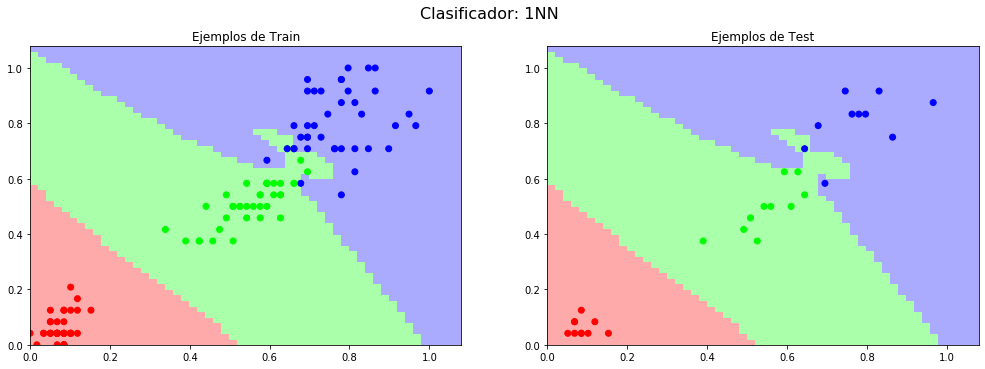

Dataset banana
Resultados sin pre-procesar con 1NN
Precisión en train: 0.8582547169811321
Precisión en test: 0.8971698113207547


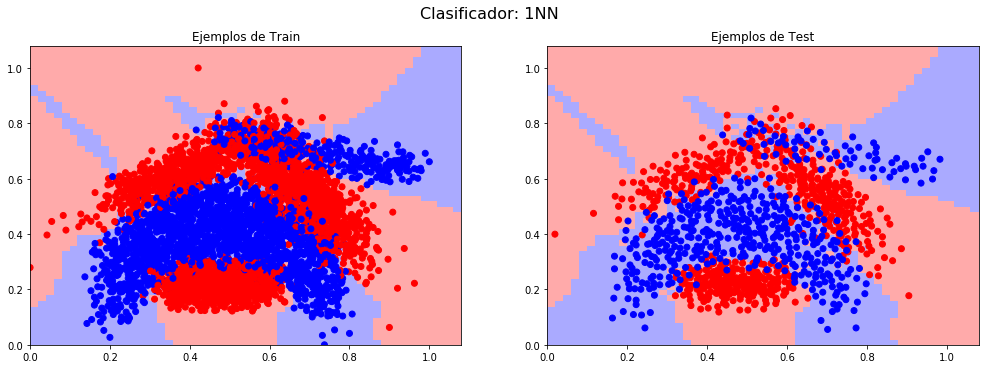

In [47]:
# Creamos el clasificador knn con neighbors.KNeighborsClassifier y n_neighbors=1
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
# Evaluamos cada dataset
for dataset in nombresDatasets:
    # Obtenemos los conjuntos de train y test del dataset
    (X_train, y_train, X_test, y_test) = datasets[dataset]
#     # "Entrenamos" knn con el conjunto de train con fit
    knn = knn.fit(X_train,y_train)
#     # Obtenemos las salidas para las instancias de train utilizando leaveOneOut con k por defecto (=1)
    salidasTrain = leaveOneOut(knn,X_train,y_train)
#     # Obtenemos la precisión en train mediante metrics.accuracy_score comparando la salida obtenida con y_train
    accTrain = metrics.accuracy_score(y_train,salidasTrain)
#     # Obtenemos las salidas para test mediante knn.predict
    predictionTest = knn.predict(X_test)
#     # Obtenemos la precisión en test mediante metrics.accuracy_score comparando la salida obtenida con y_test
    accTest = metrics.accuracy_score(y_test,predictionTest)

    # Imprimimos los resultados obtenidos
    print("Dataset " + dataset)
    print("Resultados sin pre-procesar con 1NN")
    print("Precisión en train: {}".format(accTrain))
    print("Precisión en test: {}".format(accTest))
    
    # A continuación mostramos las fronteras de decisión que obtenemos con los conjuntos de train y cómo quedan los
    # ejemplos el conjunto de test en base a dichas fronteras
    mostrar(knn, X_train, y_train, X_test, y_test)

In [48]:
Test.assertEquals(round(accTrain, 4), 0.8583, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.8972, "Precisión en test incorrecta para banana")

1 test passed.
1 test passed.


# Métodos de selección de instancias
A continuación vamos a implementar cinco métodos de selección de instancias en Python y estudiaremos su comportamiento.

Como notación, recordemos que $TR$ hace referencia al conjunto completo de instancias de entrenamiento y $S$ al conjunto de instancias seleccionadas por el método de selección.

## Edited Nearest Neighbors (ENN)

Este método funciona de la siguiente forma:
1. $S=TR$
2. Para cada ejemplo $e$ en $S$:
    * Eliminamos el ejemplo $e$ si es incorrectamente clasificado por los ejemplos en $S-\{e\}$ (las seleccionadas sin contar a ella misma)

Para la implementación, en la mayoría de los métodos representaremos las instancias seleccionadas como un vector de booleanos $S$ del tamaño del número de ejemplos, de tal forma que el valor $S[i]$ en la posición $i$ indica si el ejemplo $i$ del conjunto de entrenamiento ha sido seleccionado (True) o no (False).

Para ENN, $S$ comienza siendo un vector con todos sus elementos a True. En cada iteración, pondremos el elemento correspondiente a False y comprobaremos si es correctamente clasificado con los elementos restantes en $S$ (como $S$ es una máscara de booleanos, podemos obtener el dataset con los ejemplos seleccionados como X[S, :] e y[S]). En caso de ser correctamente clasificado, restauramos su valor a True y en otro caso, queda eliminado. 

In [49]:
def ENN(X, y, k=3):
    """
    Algoritmo ENN para la selección de instancias. Cada ejemplo se elimina si se clasifica incorrectamente por sus k vecinos más cercanos
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    # inicialmente todos los índices/instancias son seleccionadas
    S = np.ones(len(y),bool)

    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    # Para cada ejemplo, comprobamos si este es fallado al ser clasificado por sus k vecinos más cercanos (sin contar a sí mismo)
    for i in range(0, X.shape[0]):
        # Eliminamos el ejemplo de la selección para no tenerlo en cuenta al clasificarlo: modificar la máscara
        S[i]=False
        # Entrenamos knn con el conjunto de instancias seleccionadas actualmente
        knn.fit(X[S,:],y[S])
        # Si la instancia es correctamente clasificada restauramos su valor en la máscara
        prediccion = knn.predict(X[i,:].reshape(1,-1))
        if all(prediccion==y[i]):
            S[i]=True
    return S

Para poder probar el método implementado vamos a implementar una función `ejecutaMetodoIS` que la reutilizaremos con el resto de métodos. Esta función se encargará de recibir un método de selección de instancias (una función), un clasificador, un conjunto de entrenamiento y uno de test y:
1. llevará a cabo la selección de instancias con el método especificado, 
2. entrenará el clasificador con las instancias seleccionadas,
3. obtendrá la precisión en train del clasificador (mediante la función leaveOneOut),
4. obtendrá la precisión en test mediante predict
5. y calculará el ratio de reducción obtenido (qué porcentaje de instancias del conjunto de entrenamiento han sido seleccionadas).

Finalmente, imprimirá dichos datos (en caso de que el parámetro verbose sea True) y mostará gráficamente los resultados obtenidos utilizando la función mostrar.

In [50]:
def ejecutaMetodoIS(funcionMetodo, clasificador, X_train, y_train, X_test, y_test, verbose=True):
    """
    Esta función se encajar de ejecutar un método de selección de instancias y dar los resultados sobre train y test
    con el clasificador introducido como parámetro
    :param funcionMetodo: Función con el método de selección de instancias a ejecutar
    :param clasificador: Instancia del clasificador a utilizar para obtener la precisión en train y test
    :param train: Conjunto de datos de entrenamiento leído del formato keel con campos data y target
    :param test: Conjunto de datos de test leído del formato keel con campos data y target
    :return: tupla con la máscara de ejemplos seleccionados, la precisión en train, precisión en test y porcentaje de reducción obtenido
    """
    
    # Obtenemos el nombre del método. Como es una función utilizamos su campo __name__
    nombreMetodo = funcionMetodo.__name__
    if verbose:
        print ("Ejecutando " + nombreMetodo + "...")
    # Ejecutamos el método de selección de instancias correspondiente con los ejemplos de entrenamiento y sus clases
        # Utilizad todos los métodos con los parámetros por defecto y almacenad la máscara devuelta en una variable llamada S
    S = funcionMetodo(X_train,y_train)
    # Entrenamos el clasificador correspondiente solo con los ejemplos seleccionados (aplicamos la máscara S)
    clasificador.fit(X_train[S,:],y_train[S])
#     # Obtenemos las salidas para train mediante leaveOneOut
    if isinstance(clasificador, neighbors.KNeighborsClassifier):
        predictionTrain = leaveOneOut(clasificador,X_train,y_train)
    else:
        predictionTrain = clasificador.predict(X_train)
#     # Obtenemos la precisión en train con las salidas obtenidas (tanto por uno)
    accTrain = metrics.accuracy_score(y_train,predictionTrain)
#     # Obtenemos las salidas para test 
    predictionTest = clasificador.predict(X_test)
#     # Obtenemos la precisión en test  (tanto por uno)
    accTest = metrics.accuracy_score(y_test,predictionTest)
    # Calculamos el porcentaje de reducción
    reduction = (1-((float(sum(S))/len(S))))*100
        
    
    if verbose:
        print("Dataset " + dataset)
        print("Resultados " + nombreMetodo + " python")
        print("Precisión en train: {}".format(accTrain))
        print("Precisión en test: {}".format(accTest))
        print("Reducción " + nombreMetodo + ": {} de {}".format(S.sum(), S.size))
        print("Reducción: %2.2f%%" % reduction)
        # En caso de ser un árbol, imprimimos el número de reglas obtenidas
        if type(clasificador) == tree.DecisionTreeClassifier:
            print("Número de reglas: {}".format(clasificador.tree_.node_count))

    # Mostramos los resultados obtenidos por el método gráficamente
    mostrar(clasificador, X_train, y_train, X_test, y_test,  nombreMetodo, X_train[S, :], y_train[S])

    # Si es un árbol, devolvemos el número de reglas obtenidas
    nReglas = -1
    if type(clasificador) == tree.DecisionTreeClassifier:
        nReglas = clasificador.tree_.node_count
    return S, accTrain, accTest, reduction, nReglas

Con la función `ejecutaMetodoIS` implementada, podemos comprobar los resultados obtenidos por ENN en cada dataset.

¿Elimina muchos ejemplos? ¿Mejora la precisión en train? ¿y en test? ¿Qué ha pasado con las fronteras de decisión?

Ejecutando ENN...
Dataset iris
Resultados ENN python
Precisión en train: 0.975
Precisión en test: 0.9333333333333333
Reducción ENN: 117 de 120
Reducción: 2.50%


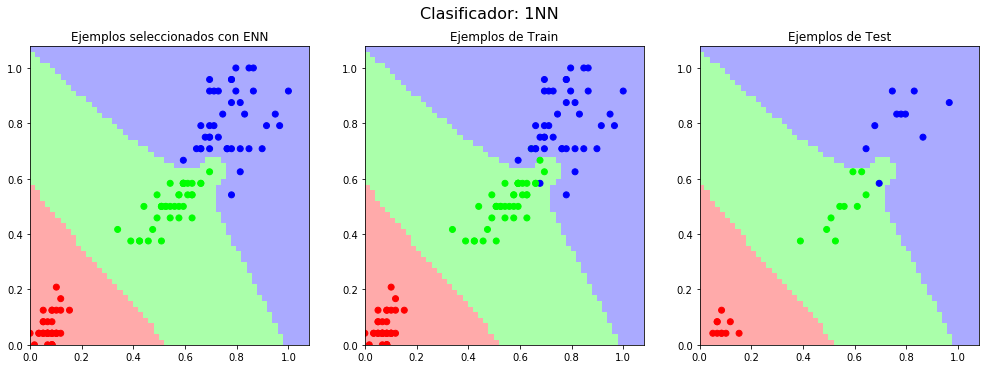

Ejecutando ENN...
Dataset banana
Resultados ENN python
Precisión en train: 0.9139150943396226
Precisión en test: 0.8962264150943396
Reducción ENN: 3822 de 4240
Reducción: 9.86%


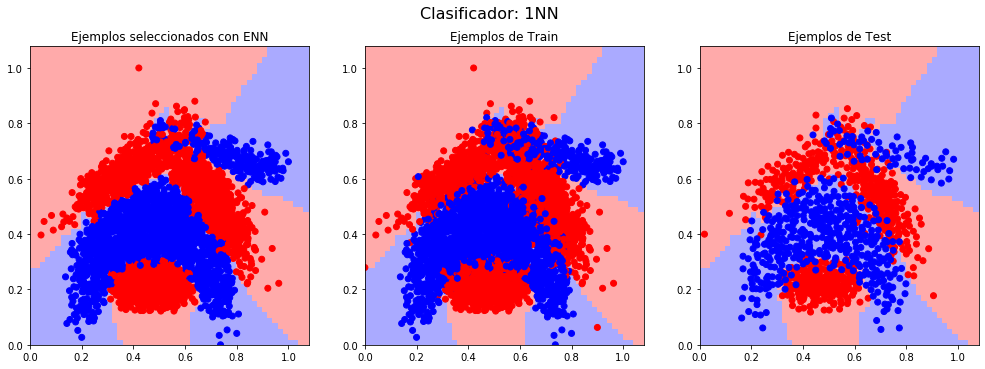

In [51]:
# Para cada dataset...
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for dataset in nombresDatasets:
    # Obtenemos el conjunto de train y el de test
    X_train, y_train, X_test, y_test = datasets[dataset]
    # Ejecutamos el método ENN con el clasificador knn creado anteriormente y los conjuntos obtenidos (train y test)
    # Con _ evitamos recibir los parámetros en variables
    S,accTrain,accTest,reduction,_ = ejecutaMetodoIS(ENN,knn,X_train, y_train, X_test, y_test)

In [52]:
Test.assertEquals(round(accTrain, 4), 0.9139, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.8962, "Precisión en test incorrecta para banana")
Test.assertEquals(round(reduction, 2), 9.86, "Porcentaje de reduccion incorrecto para banana")

1 test passed.
1 test passed.
1 test passed.


## AllKNN

Este método se basa en el anterior para decidir si eliminar una instancia o no. Básicamente, elimina aquellas instancias que son mal clasificadas utilizando kNN con cualquier valor de k entre 1 y el valor dado como parámetro.

1. $S=TR$
2. Para cada ejemplo $e$ en $S$:
    * Lo clasificamos con $k = 1...K$ utilizando $TR - \{e\}$
    * Si se clasifica incorrectamente con alguno de los valores, se etiqueta para ser eliminado (pero se mantiene en el conjunto para decidir la eliminación del resto de instancias, es decir, el conjunto de referencia es siempre $TR$).

De nuevo, representaremos las instancias seleccionadas como un vector de booleanos $S$ del tamaño del número de ejemplos, de tal forma que el valor $S[i]$ en la posición $i$ indica si el ejemplo $i$ del conjunto de entrenamiento ha sido seleccionado (True) o no (False).

Para AllKNN, $S$ comienza siendo un vector con todos sus elementos a True. En cada iteración, comprobamos si se clasifica incorrectamente con alguno de los valores de $k$ (para ello utilizamos una máscara auxiliar que nos permite eliminar el ejemplo y que su vecino más cercano no sea el mismo). En caso de ser mal clasificado, establecemos el valor $S[i]$ correspondiente a False y continúamos con el siguiente ejemplo (pero hay que tener en cuenta que $S$ no se aplica para crear el conjunto de train a la hora de predecir la clase de cada ejemplo con cualquier valor de $k$.

In [53]:
def AllKNN(X, y, k=5):
    """
    Algoritmo AllKNN para selección de instancias. Para cada instancia se prueba si se falla con 1 hasta k vecinos. 
    Si con alguno de dichos valores se clasifica incorrectamente, se marca para su eliminación (las que van a ser 
    eliminadas se consideran para el resto de instancias)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Máximo valor de k a probar en AllKNN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
        # inicialmente todos los índices/instancias son seleccionadas
    S = np.ones(len(y),bool) 
    
    # Para cada ejemplo en X, comprobamos si este es fallado con algún valor entre 1 y k de vecinos
    for i in range(0, X.shape[0]):
        Saux = np.ones(len(y),bool) # Máscara de booleanos con todo a True excepto el ejemplo que vamos a estudiar (False)
        Saux[i] = False
        for k_enn in range(1, k):
#             # Creamos el clasificador knn el k adecuado y lo "entrenamos" con todo el conjunto de instancias menos la actual
            knn = neighbors.KNeighborsClassifier(n_neighbors=k_enn)
            knn = knn.fit(X[Saux,:],y[Saux]) 
#             # En caso de fallar la predicción eliminamos la instancia y dejamos de comprobar el resto de valores de k
            prediccion = knn.predict(X[i,:].reshape(1,-1))
            if all(prediccion!=y[i]):
                S[i]=False
                break
    return S

Utiliza la función `ejecutaMetodoIS` implementada, para comprobar los resultados obtenidos por AllKNN en cada dataset.

¿Elimina muchos ejemplos? ¿Mejora la precisión en train? ¿y en test? ¿Qué ha pasado con las fronteras de decisión?

Ejecutando AllKNN...
Dataset iris
Resultados AllKNN python
Precisión en train: 0.9666666666666667
Precisión en test: 0.9666666666666667
Reducción AllKNN: 112 de 120
Reducción: 6.67%


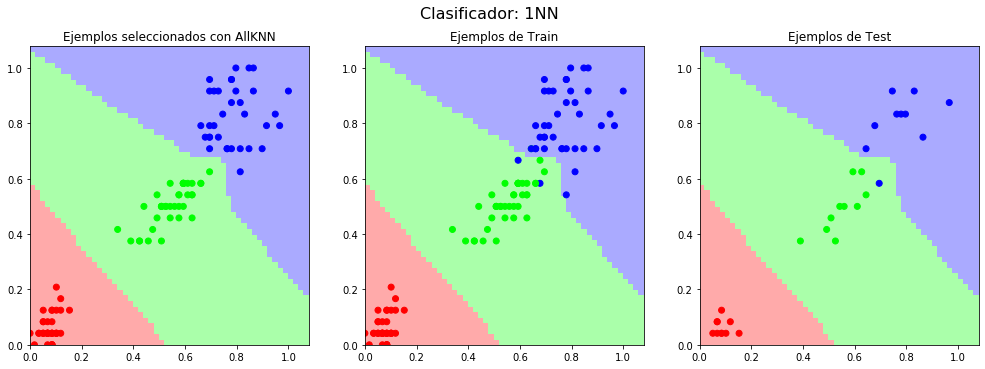

Ejecutando AllKNN...
Dataset banana
Resultados AllKNN python
Precisión en train: 0.9141509433962264
Precisión en test: 0.9028301886792452
Reducción AllKNN: 3443 de 4240
Reducción: 18.80%


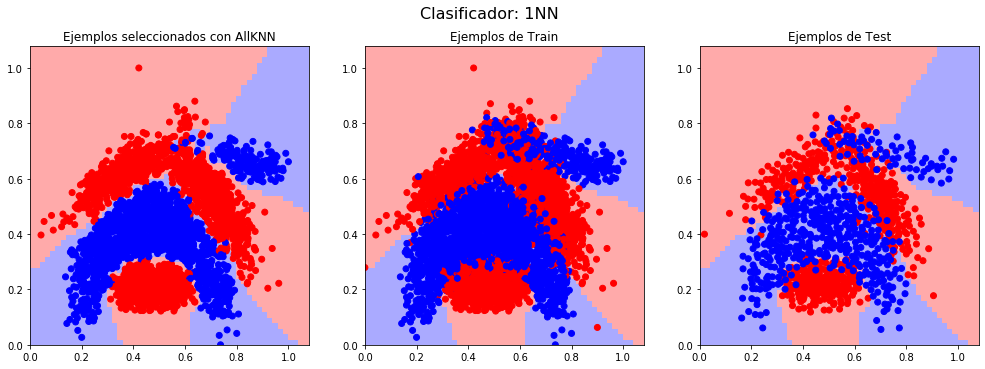

In [54]:
# Para cada dataset...
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for dataset in nombresDatasets:
    # Obtenemos el conjunto de train y el de test
    X_train, y_train, X_test, y_test = datasets[dataset]
    # Ejecutamos el método ENN con el clasificador knn creado anteriormente y los conjuntos obtenidos (train y test)
    # Con _ evitamos recibir los parámetros en variables
    S,accTrain,accTest,reduction,_ = ejecutaMetodoIS(AllKNN,knn,X_train, y_train, X_test, y_test)

In [55]:
Test.assertEquals(round(accTrain, 4), 0.9142, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.9028, "Precisión en test incorrecta para banana")
Test.assertEquals(round(reduction, 2), 18.80, "Porcentaje de reduccion incorrecto para banana")

1 test passed.
1 test passed.
1 test passed.


## Condensed Nearest Neighbor (CNN)

CNN es un método de condensación y por tanto trata de seleccionar los ejemplos en las fronteras. Básicamente, su idea es seleccionar todas aquellas instancias cuya clasificación es errónea, de tal forma que sea capaz de clasificar correctamente todo el conjunto de train (considerando como clasificación correcto cuando un ejemplo se clasifica consigo mismo).

1. $S= \emptyset$
1. Añadir un ejemplo aleatorio de cada clase a $S$
2. Para cada ejemplo $e$ en $TR$:
    * Lo clasificamos con las instancias en $S$
    * Si el ejemplo se falla, lo añadimos $S$ (aseguramos que se clasifica correctamente)
3. Repetimos el proceso hasta que todos los ejemplos restantes en $TR - S$ sean acertados (por definición, los ejemplos en $S$ se aciertan).

Las instancias seleccionadas se representan como un vector de booleanos $S$ del tamaño del número de ejemplos ($S[i]= True$ el ejemplo $i$ es seleccionado y $S[i]= False$, el ejemplo no se selecciona.

Para CNN, $S$ comienza siendo un vector con todos sus elementos a False. Lo primero que debemos hacer es añadir un ejemplo aleatorio de clada clase.

Posteriormente, como solo nos interesa evaluar los ejemplos que no están en $S$, los obtenemos mediante la negación del vector $S$. El bucle de CNN terminará cuando en un nuevo recorrido de dichos ejemplos, ninguno sea fallado. Con cada ejemplo, simplemente debemos clasificarlo con los ejemplos en $S$ y en caso de fallo añadirlo a $S$ (hacer que $S[i] = True$).

In [56]:
def CNN(X, y, k=1):
    """
    Algoritmo CNN para la selección de instancias. Se comienza con dos ejemplos aleatorios (uno de cada clase) y cada ejemplo
    que se falla al ser clasificado por los ya seleccionados se añade a la selección (se para cuando ya no se añaden más ejemplos)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = np.zeros(len(y),bool)

    # Inicialmente, seleccionamos aleatoriamente una instancia de cada clase
    # Anotamos el número de clases
    nClases = np.unique(y)
    # Para cada clase, buscamos los índices de los ejemplos de dicha clase y seleccionamos uno de ellos aleatoriamente
    # Dicho ejemplo coge el valor True en S
    for c in nClases:
        indicesClase = np.where(y == c)[0]  # np.where devuelve una tupla, nos interesa la primera parte que contiene los índices de las posiciones que no son 0 o False
        # Elegid una instancia aleatoriamente de las de la clase: utilizad randint de Numpy para ello
        instanciaAleatoria = np.random.randint(0,len(indicesClase))
        # Modificad la máscara S de acuerdo a la instancia seleccionada
        S[indicesClase[instanciaAleatoria]] = True

    # Solo evaluamos los ejemplos que no están en S (los que están se aciertan por definición al considerlos
    # como vecinos de sí mismos). Estos ejemplos son los únicos que podemos añadir a S
    notS = S==False

    # "Entrenamos" knn con los ejemplos seleccionados
    knn.fit(X[S,:],y[S])
    # Inicializamos el número de fallados para entrar en el bucle. El algoritmo termina cuando no se fallan ejemplos
    fallados = -1
    while fallados != 0:
        # Ponemos el contador de fallados a 0 y comprobamos todos los ejemplos no seleccionados
        fallados = 0
        # Obtenemos los índices de los ejemplos no seleccionados: utilizad np.where como se ha hecho anteriormente
        indices = np.where(notS)[0]
        # Para cada ejemplo no seleccionado (y en orden aleatorio) comprobamos si dicho ejemplo se falla         
        # con las instancias en S actualmente. Si se falla, el ejemplo se añade a S, se reentrena KNN y se suma uno a fallados
        for i in np.random.permutation(indices):
            pred = knn.predict(X[i,:].reshape(1,-1))
            if pred != y[i]:
                S[i] = True
                knn.fit(X[S,:],y[S])
                fallados += 1
            
        # Recalculamos los ejemplos a estudiar en la próxima iteración, aquellos no seleccionados
        notS = (S == False)
        print("CNN, fin de iteración, fallados: {}, ejemplos en S: {}".format(fallados, np.sum(S)))

    return S

Utiliza la función `ejecutaMetodoIS` implementada, para comprobar los resultados obtenidos por CNN en cada dataset.

¿Elimina muchos ejemplos? ¿Mejora la precisión en train? ¿y en test? ¿Qué ha pasado con las fronteras de decisión? ¿Hay cambios respecto a los métodos de edición (ENN, AllKNN)?

Ejecutando CNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset iris
Resultados CNN python
Precisión en train: 0.9083333333333333
Precisión en test: 0.9
Reducción CNN: 13 de 120
Reducción: 89.17%


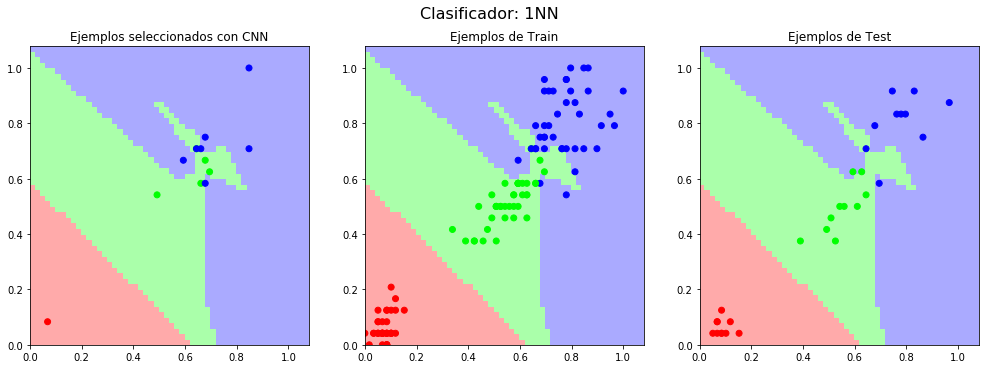

Ejecutando CNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados CNN python
Precisión en train: 0.8134433962264151
Precisión en test: 0.8896226415094339
Reducción CNN: 1017 de 4240
Reducción: 76.01%


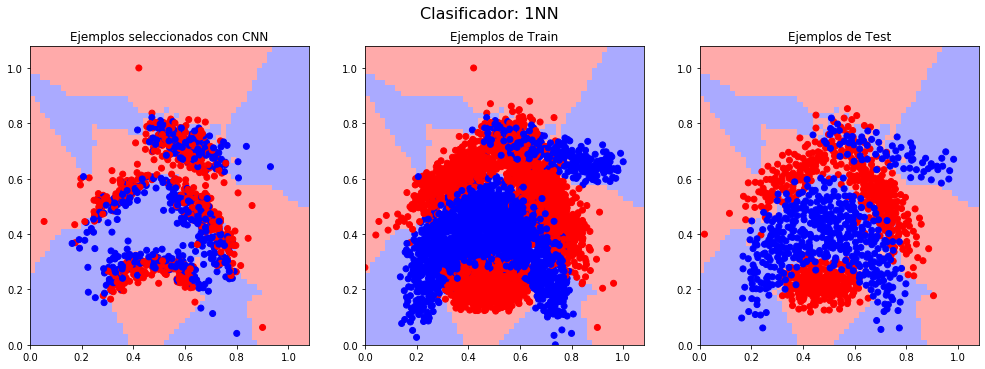

In [57]:
# Para cada dataset...
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for dataset in nombresDatasets:
    # Obtenemos el conjunto de train y el de test
    X_train, y_train, X_test, y_test = datasets[dataset]
    # Ejecutamos el método ENN con el clasificador knn creado anteriormente y los conjuntos obtenidos (train y test)
    # Con _ evitamos recibir los parámetros en variables
    S,accTrain,accTest,reduction,_ = ejecutaMetodoIS(CNN,knn,X_train, y_train, X_test, y_test)

In [58]:
Test.assertEquals(round(accTrain, 4), 0.8134, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.8896, "Precisión en test incorrecta para banana")
Test.assertEquals(round(reduction, 2), 76.01, "Porcentaje de reduccion incorrecto para banana")

1 test passed.
1 test passed.
1 test passed.


Como hemos explicado en teoría, CNN está muy influenciado por el orden en el que se cogen las instancias. De la forma en la que lo hemos implementado, dicho orden es aleatorio. Ejecuta el método con el dataset iris tres veces y comprueba la gran diferencia entre los resultados obtenidos.

Para ello, reejecuta la celda anterior con 3 semillas diferentes pero al acabar dejad la semilla inicial para que pasen los test posteriores.

## Reduced Nearest Neighbor (RNN)

RNN es un método que exitiende el anterior (CNN). CNN no asegura que el conjunto de instancias seleccionadas sea mínimo (el menor posible que clasifica correctamente todas los ejemplos de entrenamiento). RNN trata de arreglar ese problema eliminando instancias de la selección realizada por CNN. Para ello, parte de dicha selección y elimina aquellas instancias que no causan que ninguna instancia de $TR$ sea clasificada incorrectamente.

1. $S= S_{CNN}$
2. Para cada ejemplo $e$ en $S$:
    * Comprobamos si eliminar el ejemplo $e$ de $S$ no causa que ninguna instancia de $TR$ sea clasificada incorrectamente
    * En ese caso, eliminamos $e$
    
Las instancias seleccionadas se representan como un vector de booleanos $S$ del tamaño del número de ejemplos ($S[i]= True$ el ejemplo $i$ es seleccionado y $S[i]= False$, el ejemplo no se selecciona.

Para RNN, $S$ comienza siendo el vector devuelto por CNN.

Después, recorremos cada ejemplo en $S$ (con orden aleatorio) y comprobamos si la eliminación de dicho ejemplo provoca que algún ejemplo que no está en $S$ sea fallado por los ejemplos que se quedarían en $S$ (es decir, $S$ menos el ejemplo a eliminar). Si se falla algún ejemplo, la instancia no se elimina, en otro caso se puede desechar. 

In [59]:
def RNN(X, y, k=1):
    """
    Algoritmo RNN para la selección de instancias. Se parte de la selección obtenida con CNN y se eliminan aquellas instancias
    que no provoquen que se falle ninguna instancia no seleccionada (las seleccionadas se aciertan por definición al estar en el subconjunto)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    # En RNN partimos de la selección realizada por CNN y eliminamos ejemplos de la misma
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = CNN(X,y,k)

    # Entrenamos KNN con el conjunto de instancias seleccionadas por CNN
    knn.fit(X[S,:],y[S])
    # Obtenemos la máscara de instancias no seleccionadas
    # No podemos fallar ninguna de estas si queremos eliminar una instancia de S
    notS = (S==False)
    # Recorremos las instancias seleccionadas para ver si podemos eliminarlas o no
    # Obtenemos para ello los índices de las instancias: utilizad np.where
    indices = np.where(S)[0]
    #  y las recorremos aleatoriamente
    for i in np.random.permutation(indices):
        # Asumimos que podemos eliminar la instancia y la "eliminamos" temporalmente: intercambio de valores en las máscaras S y Snot
        S[i] = False
        notS[i] = True
        # Entrenamos knn una vez eliminada la instancia
        knn.fit(X[S,:], y[S])
        # Obtenemos las salidas para los ejemplos que no están seleccionados
        salidas = knn.predict(X[notS,:])
        # Si todos los ejemplos no seleccionados son acertados (no se falla ninguno) mantenemos la eliminación (no hacemos nada)
            # En otro caso, si fallamos alguna instancia, debemos restablecer la instancia eliminada: deshacer el intercambio en las máscaras
        if any(salidas.ravel() != y[notS]):
            notS[i] = False
            S[i] = True  

    return S

Utiliza la función ejecutaMetodoIS implementada, para comprobar los resultados obtenidos por RNN en cada dataset.

¿Elimina muchos ejemplos? ¿Mejora la precisión en train? ¿y en test? ¿Qué ha pasado con las fronteras de decisión? ¿Hay cambios respecto a CNN?

Ejecutando RNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset iris
Resultados RNN python
Precisión en train: 0.9083333333333333
Precisión en test: 0.9
Reducción RNN: 10 de 120
Reducción: 91.67%


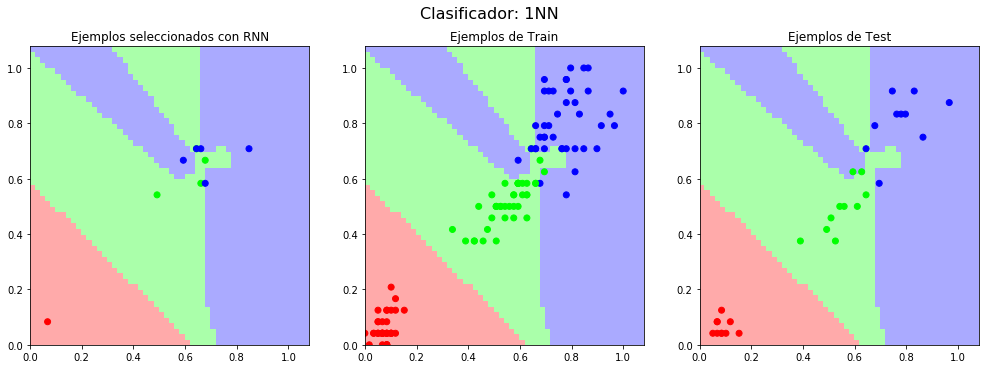

Ejecutando RNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados RNN python
Precisión en train: 0.8153301886792453
Precisión en test: 0.8849056603773585
Reducción RNN: 831 de 4240
Reducción: 80.40%


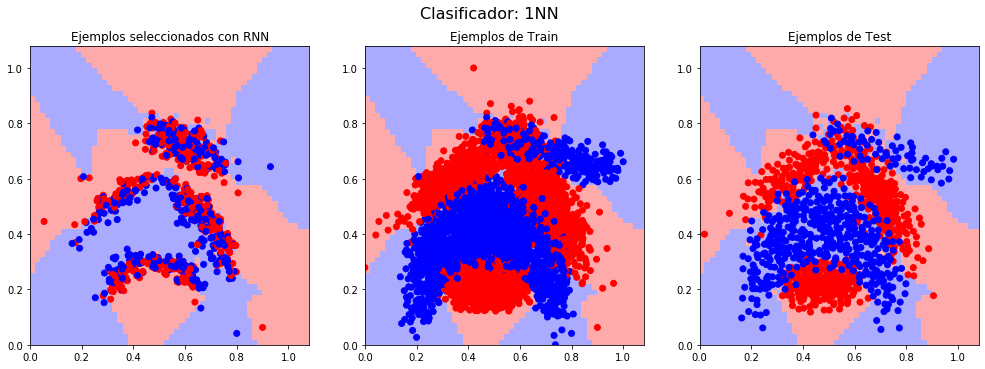

In [60]:
# Para cada dataset...
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for dataset in nombresDatasets:
    # Obtenemos el conjunto de train y el de test
    X_train, y_train, X_test, y_test = datasets[dataset]
    # Ejecutamos el método ENN con el clasificador knn creado anteriormente y los conjuntos obtenidos (train y test)
    # Con _ evitamos recibir los parámetros en variables
    S,accTrain,accTest,reduction,_ = ejecutaMetodoIS(RNN,knn,X_train, y_train, X_test, y_test)

In [61]:
Test.assertEquals(round(accTrain, 4), 0.8153, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.8849, "Precisión en test incorrecta para banana")
Test.assertEquals(round(reduction, 2), 80.40, "Porcentaje de reduccion incorrecto para banana")

1 test passed.
1 test passed.
1 test passed.


## Random Mutation Hill Climbing (RMHC)

RMHC a diferencia de los anteriores es un método de selección híbrido, que trata de buscar el mejor subconjunto de instancias en base a la precisión obtenida por el mismo mediante leave-one-out. El número de instancias seleccionadas en RMHC es fijo (en este caso lo hemos implementado como un porcentaje $s$ del tamaño del conjunto de entrenamiento).

El método es muy simple.

1. $S=$ conjunto aleatorio de instancias de $TR$ de tamaño $s\cdot |TR|$
2. En cada iteración (hasta $iteraciones$)
    * Se intercambia una instancia de $S$ con otra de $TR-S$
    * El cambio se mantiene si la precisión mejora (leave-one-out para obtenerla)
    
En este caso y por facilidad, aunque la salida final sigue siendo la máscara que indica las instancias seleccionadas, para implementar el algoritmo usamos dos listas, una de instancias seleccionadas  y otra de no seleccionadas. De esta forma resulta más sencillo intercambiar instancias de una a otra (ambas mantendrán siempre el mismo tamaño). Cada lista (o array) contiene los índices de las instancias seleccionadas o no seleccionadas.

Inicialmente dichas listas son aleatorias y en cada iteración se elige un elemento de cada lista al azar para ser intercambiados. Se realiza el cambio, se comprueba la precisión mediante leave-one-out, y en caso de mejora el cambio se mantiene. En otro caso, el cambio se deshace.

In [62]:
def RMHC(X, y, s=0.1, iteraciones=1000, k=1):
    """
     Algoritmo RMHC (Random Mutation Hill Climbing) para la selección de instancias.
      Se comienza con una selección aleatoria de s * nEjemplos instancias. Para cada iteración, se elige una instancia
      seleccionada y una no seleccionada para ser intercambiadas. Si el intercambio mejora la precisión (leave-one-out) sobre train
      se mantiene el cambio, sino se deshace
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param s: Porcentaje de instancias a ser seleccionadas (s es un valor entre 0 y 1)
    :param iteraciones: Número de iteraciones (intercambios) a probar
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RMHC establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors =k)
    
    S = np.zeros(X.shape[0],bool)
    # En este caso vamos a mantener dos vectores de enteros con los índices de las instancias seleccionadas y no seleccionadas
    # Establecemos el número de instancias a seleccionar (es fijo)
    nSel = int(s * X.shape[0])
    # Obtenemos una permutación aleatoria de todos los índices disponibles 
    # (un array de 0 a X.shape[0] con valores ordenados aleatoriamente): utilizad permutation de Numpy
    permute = np.random.permutation(X.shape[0])
    # Cogemos como seleccionadas las instancias correspondientes a los primeros nSel índices  y no seleccionadas el resto
    seleccionadas = permute[:nSel]
    noSeleccionadas = permute[nSel:]

    # Calculamos la preicisión con la selección inicial
    # Entrenamos KNN con las instancias seleccionadas
    knn = knn.fit(X[seleccionadas,:], y[seleccionadas])
    # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
    salidas = leaveOneOut(knn, X, y)
    # Calculamos la precisión
    acc = metrics.accuracy_score(salidas, y)

    # Comenzamos las iteraciones:
    #   En cada una, intercambiamos una instancia seleccionada con una que no lo está y comprobamos si mejora la precisión
    for i in range(0, iteraciones):
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a eliminar de las seleccionadas: randint de Numpy
        quitar = np.random.randint(low=0, high= len(seleccionadas))
        # Seleccionamos un índice de manera aleatoria que nos indica la instancia a añadir a las seleccionadas: randint de Numpy
        poner =np.random.randint(low=0, high=len(noSeleccionadas))
        # Guardamos el ejemplo eliminado
        aux = seleccionadas[quitar]
        # Añadimos la nueva instancia seleccionada sustituyendo la que se elimina: intercambio en las listas de seleccionados y no seleccionados
        seleccionadas[quitar] = noSeleccionadas[poner]
        # Entrenamos de nuevo kNN
        knn = knn.fit(X[seleccionadas,:],y[seleccionadas])

        # Calculamos la precisión de la solución actual
        # Obtenemos las salidas con leaveOneOut (para no tener en cuenta las instancias seleccionadas como vecinos de sí mismas)
        salidas = leaveOneOut(knn, X, y)
        # Calculamos la precisión
        accNew = metrics.accuracy_score(salidas, y)

        # Si la precisión actual es peor que la anterior, devolvemos la instancia eliminada a las seleccionadas
        # Sino si la precisión de la solución actual es mejor o igual que la anterior, guardamos la precisión y
        #  añadimos la instancia eliminada a las no seleccionadas
        if accNew >= acc:
            acc = accNew
            noSeleccionadas[poner]=aux
        else:
            seleccionadas[quitar] = aux

        if i % 100 == 0:
            print("precision en iteracion {}: {}".format(i, acc))

    # A partir de las seleccionadas creamos la máscara de instancias seleccionadas 
    # donde True en la posición i indica que la instancia i es seleccionada
    S[seleccionadas] = True

    return S

Utiliza la función ejecutaMetodoIS implementada, para comprobar los resultados obtenidos por RMHC en cada dataset.

¿Elimina muchos ejemplos? ¿Mejora la precisión en train? ¿y en test? ¿Qué ha pasado con las fronteras de decisión? ¿Notas cambios respecto a los métodos de edición o condensación?

Ejecutando RMHC...
precision en iteracion 0: 0.9666666666666667
precision en iteracion 100: 0.975
precision en iteracion 200: 0.975
precision en iteracion 300: 0.975
precision en iteracion 400: 0.975
precision en iteracion 500: 0.975
precision en iteracion 600: 0.975
precision en iteracion 700: 0.975
precision en iteracion 800: 0.975
precision en iteracion 900: 0.975
Dataset iris
Resultados RMHC python
Precisión en train: 0.975
Precisión en test: 0.9666666666666667
Reducción RMHC: 12 de 120
Reducción: 90.00%


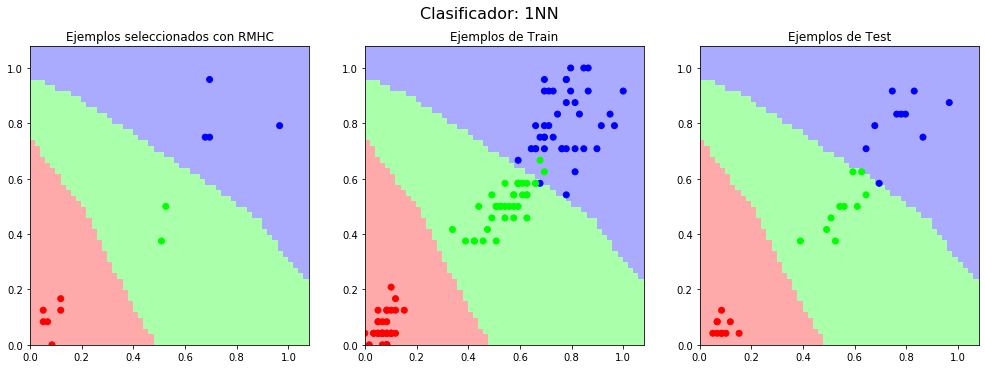

Ejecutando RMHC...
precision en iteracion 0: 0.8575471698113207
precision en iteracion 100: 0.878066037735849
precision en iteracion 200: 0.8853773584905661
precision en iteracion 300: 0.8922169811320755
precision en iteracion 400: 0.8990566037735849
precision en iteracion 500: 0.9037735849056604
precision en iteracion 600: 0.9063679245283018
precision en iteracion 700: 0.9089622641509434
precision en iteracion 800: 0.9096698113207548
precision en iteracion 900: 0.910377358490566
Dataset banana
Resultados RMHC python
Precisión en train: 0.9117924528301887
Precisión en test: 0.9009433962264151
Reducción RMHC: 424 de 4240
Reducción: 90.00%


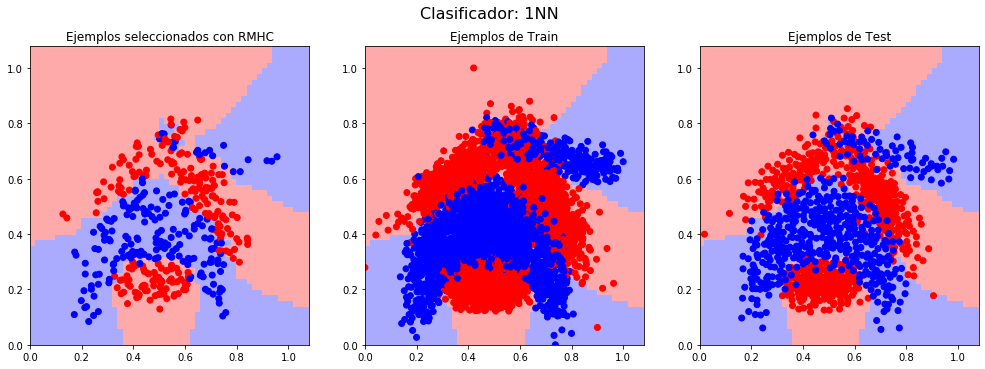

In [63]:
# Para cada dataset...
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
for dataset in nombresDatasets:
    # Obtenemos el conjunto de train y el de test
    X_train, y_train, X_test, y_test = datasets[dataset]
    # Ejecutamos el método ENN con el clasificador knn creado anteriormente y los conjuntos obtenidos (train y test)
    # Con _ evitamos recibir los parámetros en variables
    S,accTrain,accTest,reduction,_ = ejecutaMetodoIS(RMHC,knn,X_train, y_train, X_test, y_test)

In [64]:
Test.assertEquals(round(accTrain, 4), 0.9118, "Precisión en train incorrecta para banana")
Test.assertEquals(round(accTest, 4), 0.9009, "Precisión en test incorrecta para banana")
Test.assertEquals(round(reduction, 2), 90.00, "Porcentaje de reduccion incorrecto para banana")

1 test passed.
1 test passed.
1 test passed.


# Comparación de los métodos con kNN
Ya tenemos 5 métodos de selección de instancias implementados. Ahora vamos a realizar una pequeña comparativa de todos ellos a la vez.

En primer lugar y para poder continuar utilizando la función ejecutaMetodoIS, vamos a implementar una función muy tonta que simplemente no realice la selección (devuelve un array de booleanos con todo a True). Esta función nos servirá para representar el resultado del modelo sin selección posteriormente.

In [65]:
def sinSeleccion(X, y):
    S = np.ones(len(y),bool)
    return S

Por rapidez en la ejecución, vamos a realizar la comparativa con el dataset iris (pero luego puedes cambiar a banana para ver los resultados).

Establecemos una lista con los métodos de selección que vamos a testear. Posteriormente, creamos una serie de matrices y vectores vacías para obtener los resultados de cada método de selección de instancias (instancias seleccionadas, precisión en train, precisión en test y reducción).

Con estas listas luego seremos capaces de montar una tabla con la que comparar rápidamente los resultados.

Al ejecutar el siguiente código podrás observar los resultados de cada método gráficamente.

Ejecutando sinSeleccion...
Dataset banana
Resultados sinSeleccion python
Precisión en train: 0.9666666666666667
Precisión en test: 0.9333333333333333
Reducción sinSeleccion: 120 de 120
Reducción: 0.00%


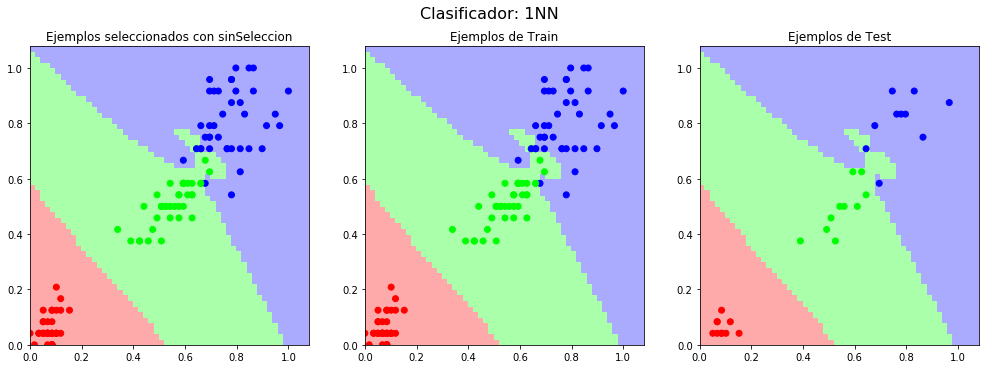

Ejecutando ENN...
Dataset banana
Resultados ENN python
Precisión en train: 0.975
Precisión en test: 0.9333333333333333
Reducción ENN: 117 de 120
Reducción: 2.50%


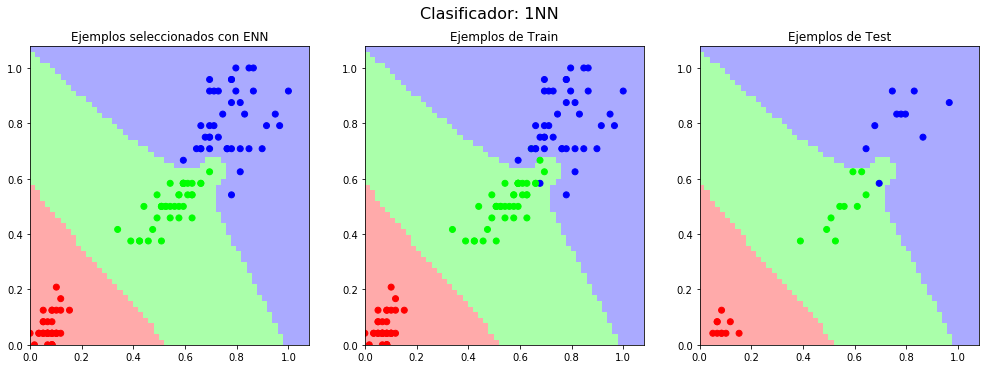

Ejecutando AllKNN...
Dataset banana
Resultados AllKNN python
Precisión en train: 0.9666666666666667
Precisión en test: 0.9666666666666667
Reducción AllKNN: 112 de 120
Reducción: 6.67%


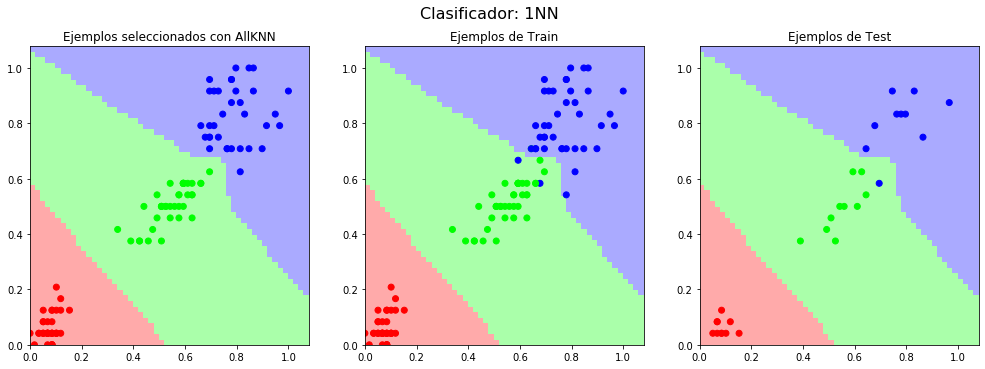

Ejecutando CNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset banana
Resultados CNN python
Precisión en train: 0.9083333333333333
Precisión en test: 0.9
Reducción CNN: 13 de 120
Reducción: 89.17%


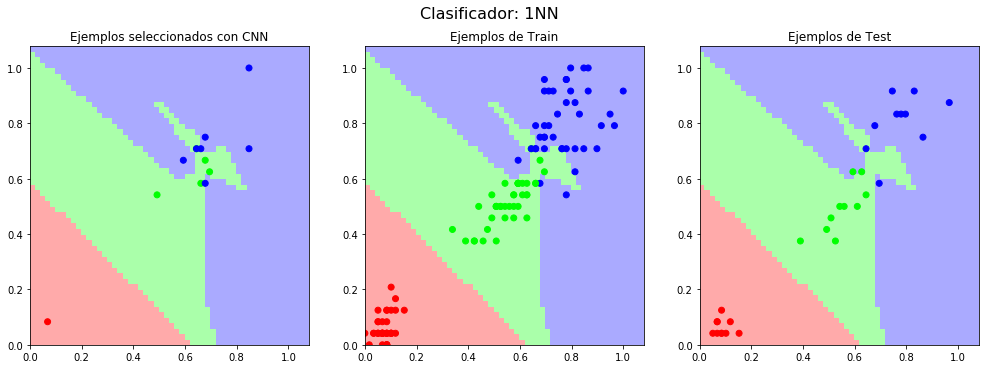

Ejecutando RNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset banana
Resultados RNN python
Precisión en train: 0.9083333333333333
Precisión en test: 0.9
Reducción RNN: 10 de 120
Reducción: 91.67%


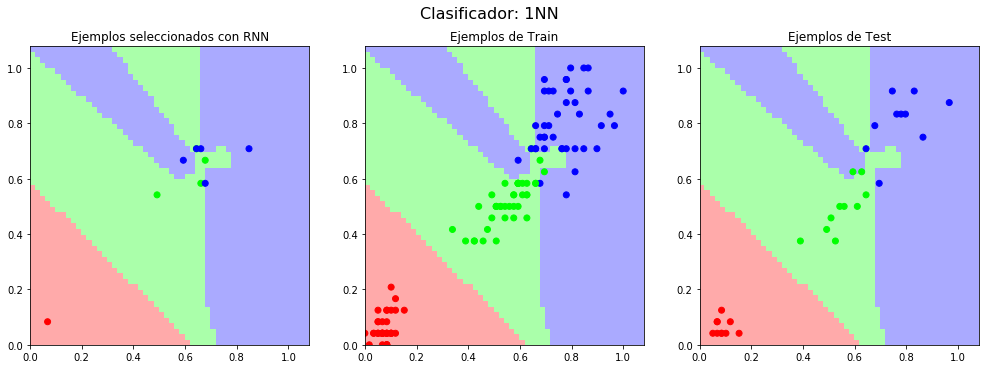

Ejecutando RMHC...
precision en iteracion 0: 0.9666666666666667
precision en iteracion 100: 0.975
precision en iteracion 200: 0.975
precision en iteracion 300: 0.975
precision en iteracion 400: 0.975
precision en iteracion 500: 0.975
precision en iteracion 600: 0.975
precision en iteracion 700: 0.975
precision en iteracion 800: 0.975
precision en iteracion 900: 0.975
Dataset banana
Resultados RMHC python
Precisión en train: 0.975
Precisión en test: 0.9666666666666667
Reducción RMHC: 12 de 120
Reducción: 90.00%


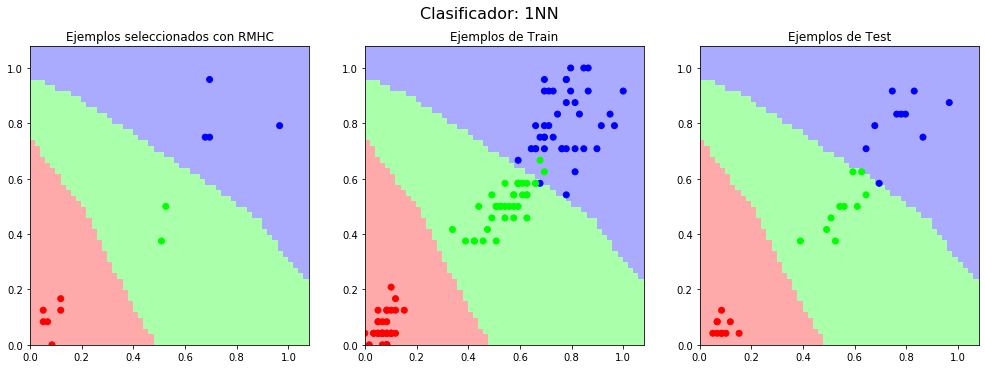

In [66]:
# Obtenemos los conjuntos de train y test de iris
X_train, y_train, X_test, y_test = datasets['iris']

# Establecemos una lista con las funciones de los métodos de selección
metodos = (sinSeleccion, ENN, AllKNN, CNN, RNN, RMHC)
# Obtenemos el número de métodos 
nMetodos = len(metodos)

# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    S[i, :], accTrain[i], accTest[i], reduction[i], _ = ejecutaMetodoIS(metodo,knn,X_train, y_train, X_test, y_test)

In [67]:
Test.assertEquals(list(map(lambda x: round(x,2), accTrain)), [0.97, 0.98, 0.97, 0.91, 0.91, 0.98], "Precisión en train incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), accTest)), [0.93, 0.93, 0.97, 0.9, 0.9, 0.97], "Precisión en test incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), reduction)), [0.0, 2.5, 6.67, 89.17, 91.67, 90.0], "Porcentaje de reduccion incorrecto")

1 test passed.
1 test passed.
1 test passed.


Repetid la comparativa anterior para el dataset Banana.

Ejecutando sinSeleccion...
Dataset banana
Resultados sinSeleccion python
Precisión en train: 0.8582547169811321
Precisión en test: 0.8971698113207547
Reducción sinSeleccion: 4240 de 4240
Reducción: 0.00%


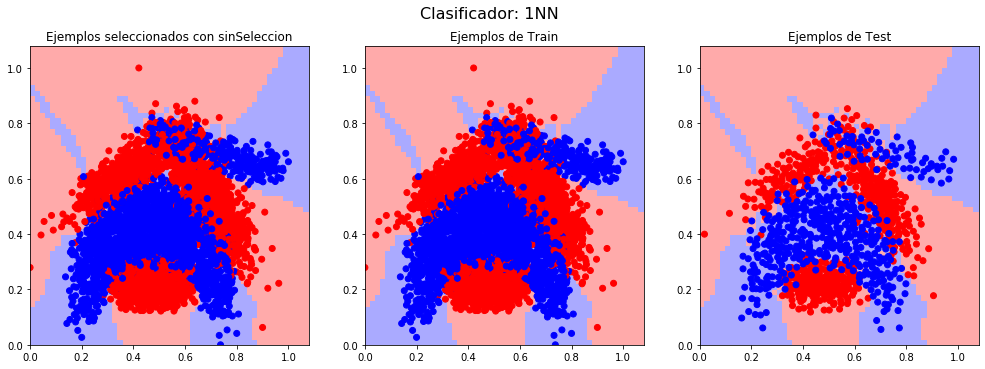

Ejecutando ENN...
Dataset banana
Resultados ENN python
Precisión en train: 0.9139150943396226
Precisión en test: 0.8962264150943396
Reducción ENN: 3822 de 4240
Reducción: 9.86%


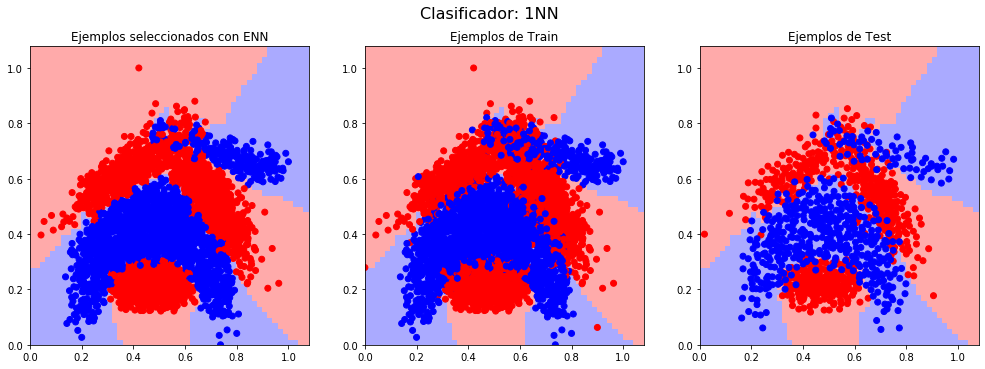

Ejecutando AllKNN...
Dataset banana
Resultados AllKNN python
Precisión en train: 0.9141509433962264
Precisión en test: 0.9028301886792452
Reducción AllKNN: 3443 de 4240
Reducción: 18.80%


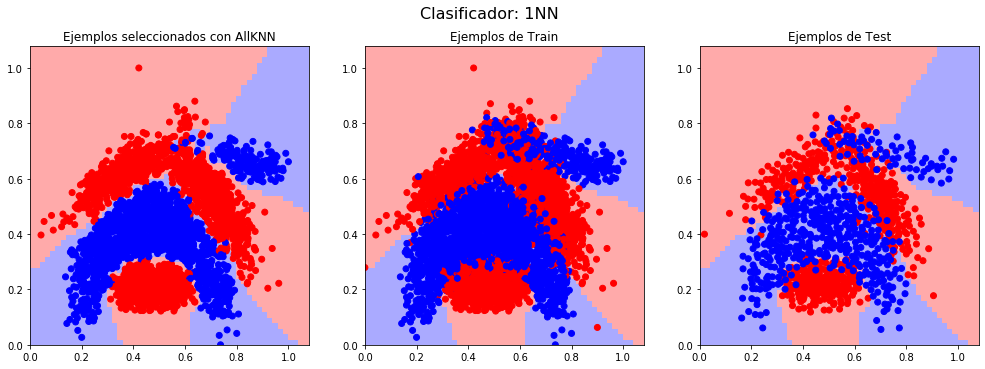

Ejecutando CNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados CNN python
Precisión en train: 0.8134433962264151
Precisión en test: 0.8896226415094339
Reducción CNN: 1017 de 4240
Reducción: 76.01%


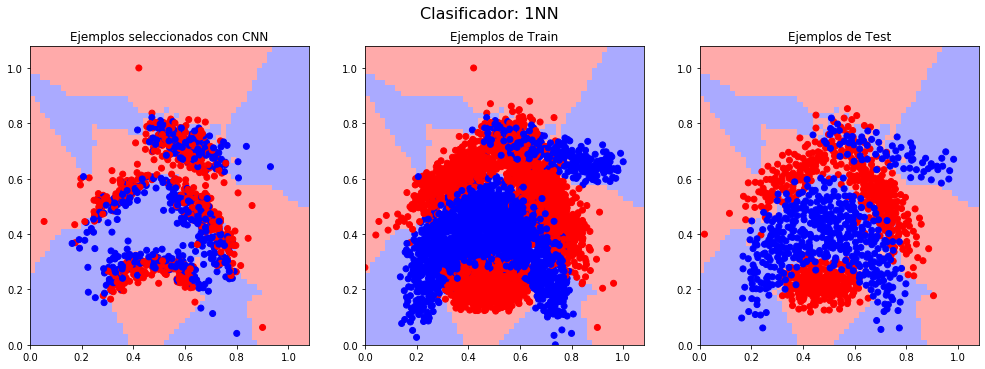

Ejecutando RNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados RNN python
Precisión en train: 0.8153301886792453
Precisión en test: 0.8849056603773585
Reducción RNN: 831 de 4240
Reducción: 80.40%


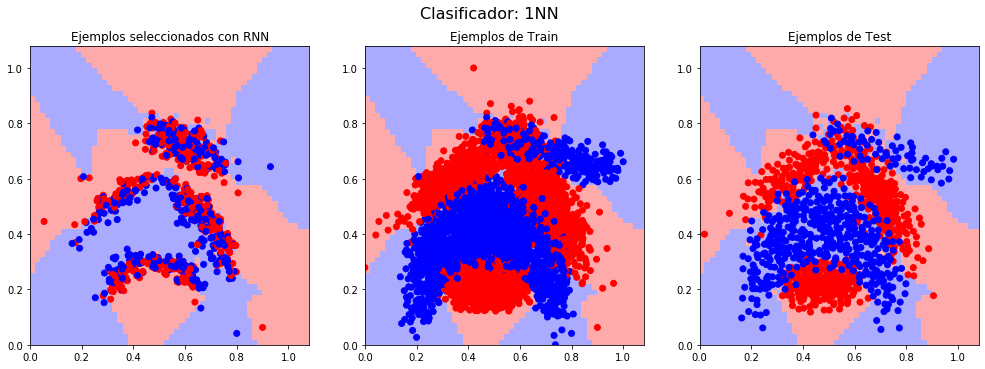

Ejecutando RMHC...
precision en iteracion 0: 0.8575471698113207
precision en iteracion 100: 0.878066037735849
precision en iteracion 200: 0.8853773584905661
precision en iteracion 300: 0.8922169811320755
precision en iteracion 400: 0.8990566037735849
precision en iteracion 500: 0.9037735849056604
precision en iteracion 600: 0.9063679245283018
precision en iteracion 700: 0.9089622641509434
precision en iteracion 800: 0.9096698113207548
precision en iteracion 900: 0.910377358490566
Dataset banana
Resultados RMHC python
Precisión en train: 0.9117924528301887
Precisión en test: 0.9009433962264151
Reducción RMHC: 424 de 4240
Reducción: 90.00%


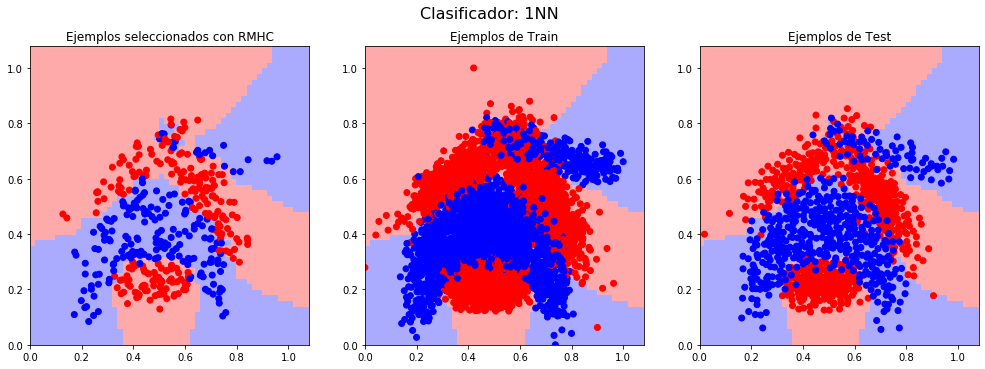

In [68]:
# Obtenemos los conjuntos de train y test de iris
X_train, y_train, X_test, y_test = datasets['banana']

# Establecemos una lista con las funciones de los métodos de selección
metodos = (sinSeleccion, ENN, AllKNN, CNN, RNN, RMHC)
# Obtenemos el número de métodos 
nMetodos = len(metodos)

# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    S[i, :], accTrain[i], accTest[i], reduction[i], _ = ejecutaMetodoIS(metodo,knn,X_train, y_train, X_test, y_test)

In [69]:
Test.assertEquals(list(map(lambda x: round(x,2), accTrain)), [0.86, 0.91, 0.91, 0.81, 0.82, 0.91], "Precisión en train incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), accTest)), [0.9, 0.9, 0.9, 0.89, 0.88, 0.9], "Precisión en test incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), reduction)), [0.0, 9.86, 18.8, 76.01, 80.4, 90.0], "Porcentaje de reduccion incorrecto")

1 test passed.
1 test passed.
1 test passed.


# Comparación de los métodos con Árboles de Decisión

Hasta ahora hemos utilizado todos los métodos de selección de instancias con kNN (sería el caso en el que a los métodos los podemos denominar como métodos de selección de prototipos).

Sin embargo, algunos de ellos son también útiles para lo que denominamos como Training Set Selection, en el que la selección se realiza de manera general para cualquier método de aprendizaje. En este caso, nosotros vamos a probarlos con los árboles de decisión.[Link a los árboles de decisión en scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Se trata de observar si su comportamiento es bueno con el árbol de decisión C4.5 (utilizad 123 como valor de semilla en el constructor y el resto de sus parámetros dejadlos por defecto), si todos ellos funcionan o solo algunos y cuáles en ese caso. Veremos además como una de las propiedades interesante de la selección de instancias en este tipo de modelos es que los simplifican, reduciendo en gran medida el número de reglas obtenidas. Para ello, es necesario recoger el último parámetro devuelto por la función *ejecutaMetodoIS* y crear un lista llamada *nRules* que recoja el resultado de cada método.

Ejecutando sinSeleccion...
Dataset banana
Resultados sinSeleccion python
Precisión en train: 0.9916666666666667
Precisión en test: 0.9666666666666667
Reducción sinSeleccion: 120 de 120
Reducción: 0.00%
Número de reglas: 15


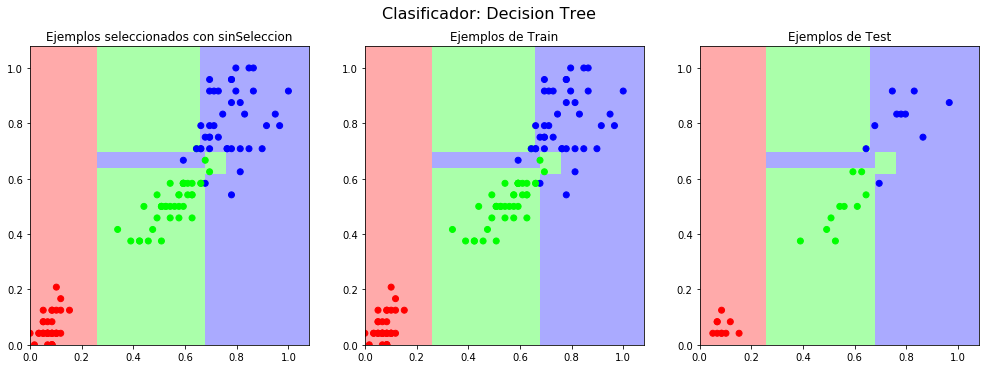

Ejecutando ENN...
Dataset banana
Resultados ENN python
Precisión en train: 0.975
Precisión en test: 0.9666666666666667
Reducción ENN: 117 de 120
Reducción: 2.50%
Número de reglas: 7


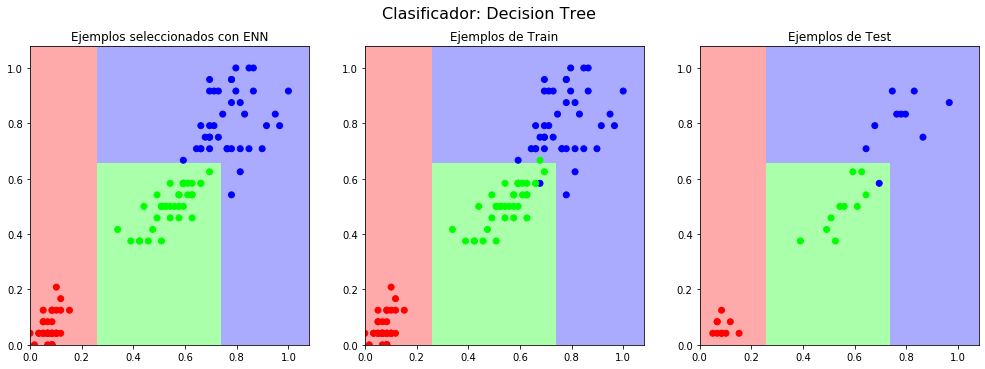

Ejecutando AllKNN...
Dataset banana
Resultados AllKNN python
Precisión en train: 0.9666666666666667
Precisión en test: 0.9666666666666667
Reducción AllKNN: 112 de 120
Reducción: 6.67%
Número de reglas: 9


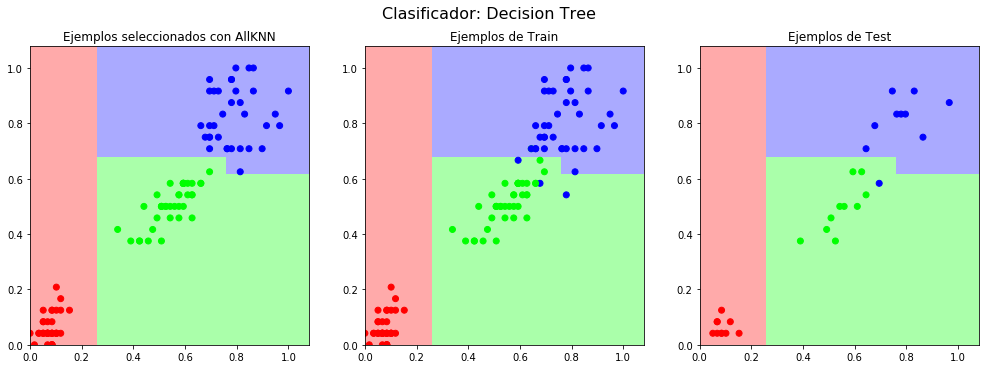

Ejecutando CNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset banana
Resultados CNN python
Precisión en train: 0.8416666666666667
Precisión en test: 0.8333333333333334
Reducción CNN: 13 de 120
Reducción: 89.17%
Número de reglas: 15


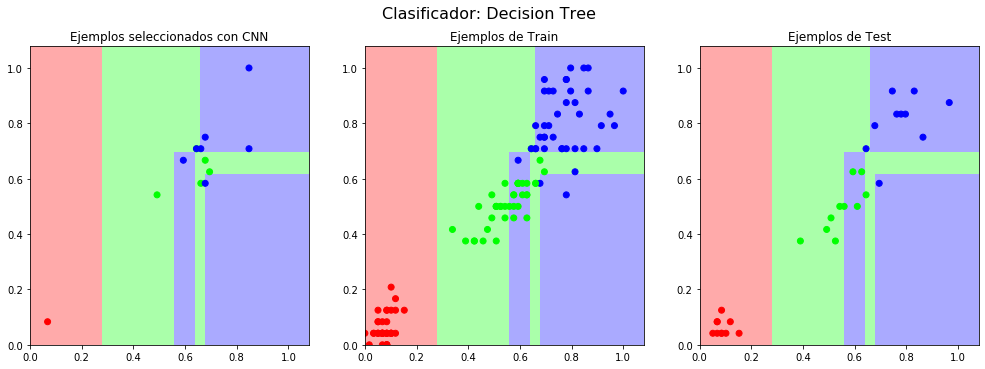

Ejecutando RNN...
CNN, fin de iteración, fallados: 9, ejemplos en S: 12
CNN, fin de iteración, fallados: 1, ejemplos en S: 13
CNN, fin de iteración, fallados: 0, ejemplos en S: 13
Dataset banana
Resultados RNN python
Precisión en train: 0.875
Precisión en test: 0.8666666666666667
Reducción RNN: 10 de 120
Reducción: 91.67%
Número de reglas: 17


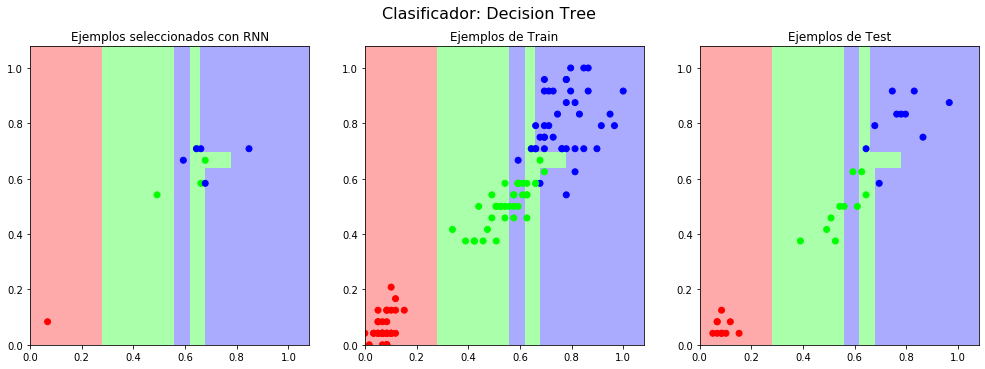

Ejecutando RMHC...
precision en iteracion 0: 0.9666666666666667
precision en iteracion 100: 0.975
precision en iteracion 200: 0.975
precision en iteracion 300: 0.975
precision en iteracion 400: 0.975
precision en iteracion 500: 0.975
precision en iteracion 600: 0.975
precision en iteracion 700: 0.975
precision en iteracion 800: 0.975
precision en iteracion 900: 0.975
Dataset banana
Resultados RMHC python
Precisión en train: 0.9
Precisión en test: 0.9
Reducción RMHC: 12 de 120
Reducción: 90.00%
Número de reglas: 5


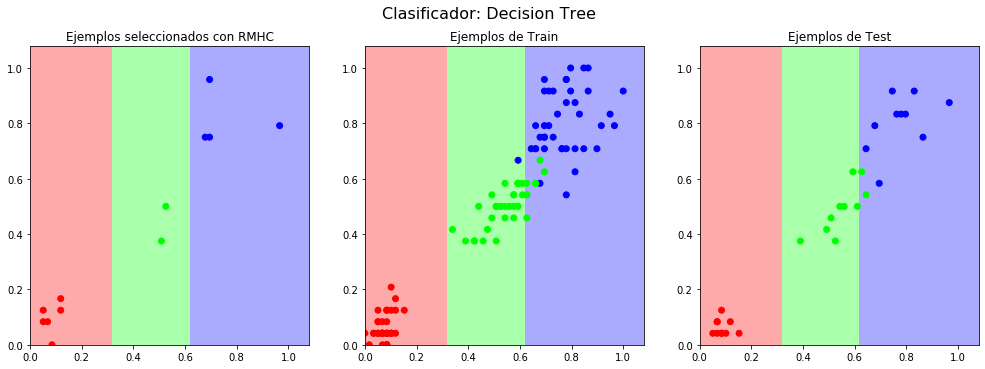

In [70]:
from sklearn import tree
X_train, y_train, X_test, y_test = datasets['iris']
metodos = (sinSeleccion, ENN, AllKNN, CNN, RNN, RMHC)
# Obtenemos el número de métodos 
nMetodos = len(metodos)

# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
nRules = np.zeros((nMetodos))

decisionTree = tree.DecisionTreeClassifier(criterion='entropy',random_state=123)

for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    S[i, :], accTrain[i], accTest[i], reduction[i], nRules[i] = ejecutaMetodoIS(metodo,decisionTree,X_train, y_train, X_test, y_test)

In [71]:
Test.assertEquals(list(map(lambda x: round(x,2), accTrain)), [0.99, 0.98, 0.97, 0.84, 0.88, 0.9], "Precisión en train incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), accTest)), [0.97, 0.97, 0.97, 0.83, 0.87, 0.9], "Precisión en test incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), reduction)), [0.0, 2.5, 6.67, 89.17, 91.67, 90.0], "Porcentaje de reduccion incorrecto")
Test.assertEquals(list(map(lambda x: int(x), nRules)), [15, 7, 9, 15, 17, 5], "Numero de reglas incorrecto")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


Repetid la comparativa anterior para el dataset Banana.

Ejecutando sinSeleccion...
Dataset banana
Resultados sinSeleccion python
Precisión en train: 1.0
Precisión en test: 0.8830188679245283
Reducción sinSeleccion: 4240 de 4240
Reducción: 0.00%
Número de reglas: 999


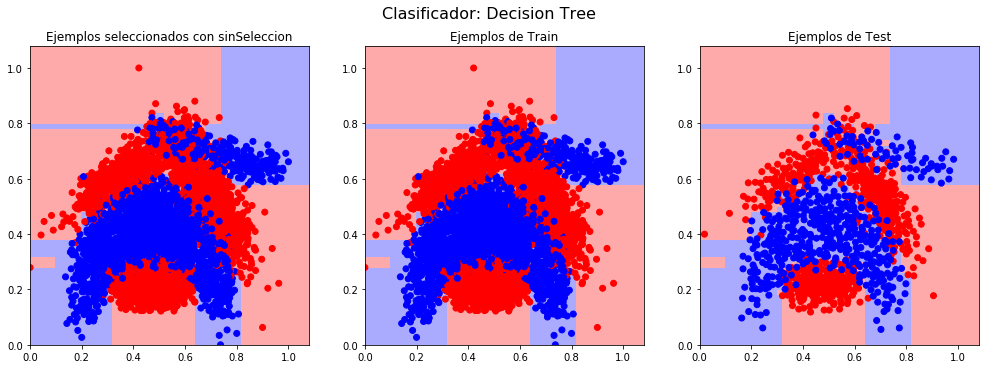

Ejecutando ENN...
Dataset banana
Resultados ENN python
Precisión en train: 0.925
Precisión en test: 0.8952830188679245
Reducción ENN: 3822 de 4240
Reducción: 9.86%
Número de reglas: 193


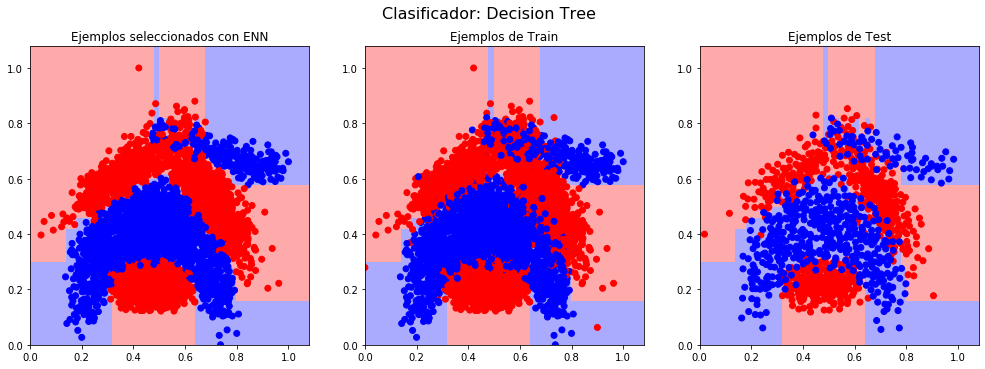

Ejecutando AllKNN...
Dataset banana
Resultados AllKNN python
Precisión en train: 0.9122641509433962
Precisión en test: 0.8943396226415095
Reducción AllKNN: 3443 de 4240
Reducción: 18.80%
Número de reglas: 87


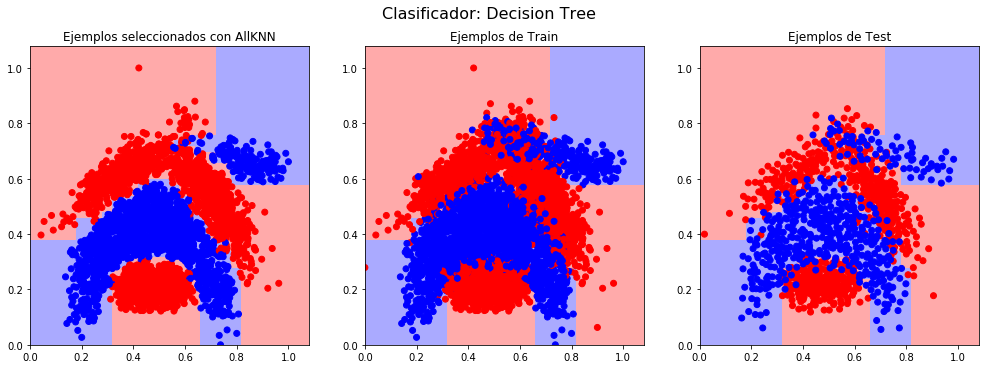

Ejecutando CNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados CNN python
Precisión en train: 0.9391509433962264
Precisión en test: 0.8433962264150944
Reducción CNN: 1017 de 4240
Reducción: 76.01%
Número de reglas: 827


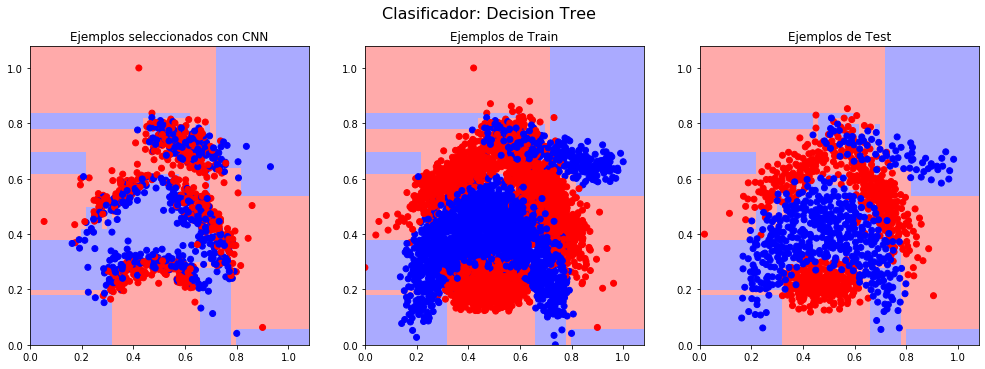

Ejecutando RNN...
CNN, fin de iteración, fallados: 744, ejemplos en S: 746
CNN, fin de iteración, fallados: 239, ejemplos en S: 985
CNN, fin de iteración, fallados: 28, ejemplos en S: 1013
CNN, fin de iteración, fallados: 3, ejemplos en S: 1016
CNN, fin de iteración, fallados: 1, ejemplos en S: 1017
CNN, fin de iteración, fallados: 0, ejemplos en S: 1017
Dataset banana
Resultados RNN python
Precisión en train: 0.8577830188679245
Precisión en test: 0.7650943396226415
Reducción RNN: 831 de 4240
Reducción: 80.40%
Número de reglas: 801


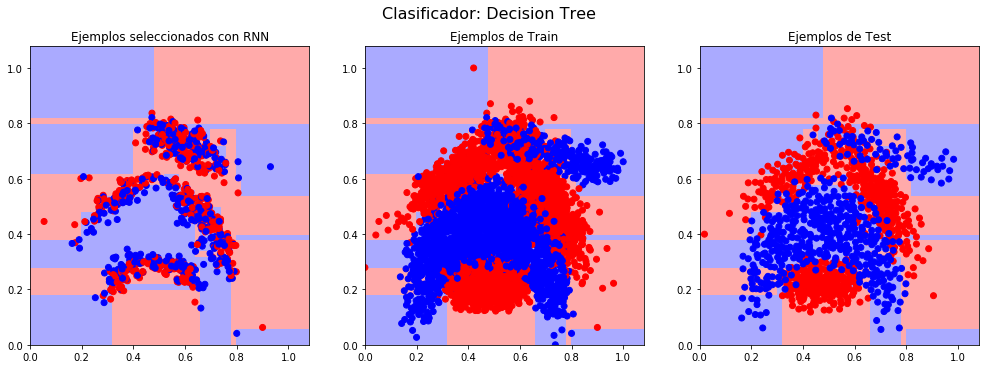

Ejecutando RMHC...
precision en iteracion 0: 0.8575471698113207
precision en iteracion 100: 0.878066037735849
precision en iteracion 200: 0.8853773584905661
precision en iteracion 300: 0.8922169811320755
precision en iteracion 400: 0.8990566037735849
precision en iteracion 500: 0.9037735849056604
precision en iteracion 600: 0.9063679245283018
precision en iteracion 700: 0.9089622641509434
precision en iteracion 800: 0.9096698113207548
precision en iteracion 900: 0.910377358490566
Dataset banana
Resultados RMHC python
Precisión en train: 0.8884433962264151
Precisión en test: 0.8764150943396226
Reducción RMHC: 424 de 4240
Reducción: 90.00%
Número de reglas: 67


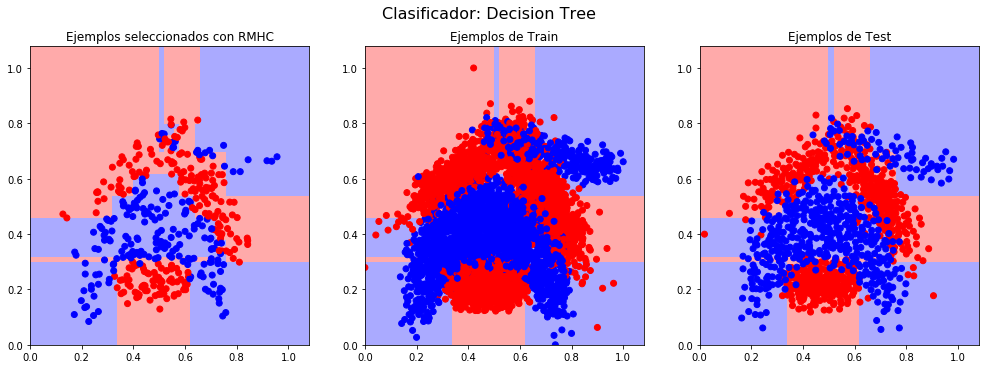

In [72]:
from sklearn import tree
X_train, y_train, X_test, y_test = datasets['banana']
metodos = (sinSeleccion, ENN, AllKNN, CNN, RNN, RMHC)
# Obtenemos el número de métodos 
nMetodos = len(metodos)

# Inicializamos las variables para guardar los resultados
S = np.zeros((nMetodos, X_train.shape[0]))
accTrain = np.zeros((nMetodos))
accTest = np.zeros((nMetodos))
reduction = np.zeros((nMetodos))
nRules = np.zeros((nMetodos))

decisionTree = tree.DecisionTreeClassifier(criterion='entropy',random_state=123)

for i, metodo in enumerate(metodos):
    # Ejecutamos cada método con knn y los conjuntos de train y test de iris, ponemos verbose=False
    S[i, :], accTrain[i], accTest[i], reduction[i], nRules[i] = ejecutaMetodoIS(metodo,decisionTree,X_train, y_train, X_test, y_test)

In [73]:
Test.assertEquals(list(map(lambda x: round(x,2), accTrain)), [1.0, 0.92, 0.91, 0.94, 0.86, 0.89], "Precisión en train incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), accTest)), [0.88, 0.9, 0.89, 0.84, 0.77, 0.88], "Precisión en test incorrecta")
Test.assertEquals(list(map(lambda x: round(x,2), reduction)), [0.0, 9.86, 18.8, 76.01, 80.4, 90.0], "Porcentaje de reduccion incorrecto")
Test.assertEquals(list(map(lambda x: round(x,2), nRules)), [999, 193, 87, 827, 801, 67], "Numero de reglas incorrecto")

1 test passed.
1 test passed.
1 test passed.
1 test passed.
